# An example of moving the fiber in the fiberloss calculation

This example is to illustrate how one can move the fiber in specsim
It is basically another variable needed when initializing the fiberloss.GalsimFiberlossCalculator

In [1]:
# general packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.table

# specsim (DESI related packages)
import specsim
import specsim.quickspecsim as qspecsim
import specsim.instrument as inst
import specsim.source as src
import specsim.config as conf
import specsim.fiberloss as floss
import specsim.observation as obs
import specsim.simulator as sim
import specsim.atmosphere as atm

print('imports complete')

imports complete


In [2]:
# Create a simulator object using the given configuration
desi = sim.Simulator('/home/tyapici/Projects/DESI_projects/dithering/config/desi-blur.yaml')
print('desi-like model created')

desi-like model created


In [3]:
# function to generate the wavelength values
def create_wlen_grid(num_wlen=40, desi=desi):
    wavelength = desi.simulated['wavelength']
    wlen_unit = wavelength.unit
    return np.linspace(wavelength.data[0], wavelength.data[-1], num_wlen) * wlen_unit

# function to generate mock sources
def generate_source(disk_fraction=0., bulge_fraction=0., vary='', seed=23, minormajor=[1,1]):
    gen = np.random.RandomState(seed)
    varied = vary.split(',')
    source_fraction = np.array([disk_fraction, bulge_fraction])
    source_half_light_radius = np.array([0.45, 1.0])
    source_minor_major_axis_ratio = np.array(minormajor)
    if 'pa' in varied:
        source_position_angle = 360. * gen.uniform(size=(1, 2))
    else:
        source_position_angle = np.array([0., 0.])
    return source_fraction, source_half_light_radius, source_minor_major_axis_ratio, source_position_angle

In [4]:
# some constants
num_pixels = 32
oversampling = 32
wlen_grid = create_wlen_grid()

In [5]:
focal_x, focal_y    = desi.observation.locate_on_focal_plane(desi.source.sky_position, desi.instrument)
scale, blur, offset = desi.instrument.get_focal_plane_optics([focal_x.value]*u.mm, [focal_y.value]*u.mm, wlen_grid)
seeing_fwhm         = desi.atmosphere.get_seeing_fwhm(wlen_grid).to(u.arcsec).value
source              = generate_source()
fiber_diameter      = desi.instrument.fiber_diameter.to(u.um).value

In [14]:
def plot_aperture(galsim_obj):
    aperture = galsim_obj.aperture
    x = []
    y = []
    c = []
    for i in range(num_pixels):
        for j in range(num_pixels):
            x.append( (j+1) * fiber_diameter/(num_pixels) - fiber_diameter/(2.))
            y.append( (i+1) * fiber_diameter/(num_pixels) - fiber_diameter/(2.))
            c.append( aperture[i][j] )
    x = np.array(x)
    y = np.array(y)
    c = np.array(c)
    plt.clf()
    plt.hist2d(x, y, weights=c, bins=num_pixels)
    plt.axes().set_aspect('equal')
    plt.xlabel("X position [um]")
    plt.ylabel("Y position [um]")
    plt.colorbar()
    plt.show()

In [15]:
# this is where the magic happens
cGalsim = floss.GalsimFiberlossCalculator(desi.instrument.fiber_diameter.to(u.um).value,
                                          wlen_grid.to(u.Angstrom).value,
                                          num_pixels=num_pixels, oversampling=oversampling, moffat_beta=3.5, 
                                          fiber_placement=np.array([80, 0]))

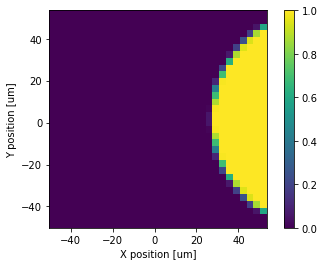

In [16]:
plot_aperture(cGalsim)